## Exploring Strategies with Distributed Data

1. Work with **all** of the data with **spark**

    \+ most accurate reports    
    \- limited by the operations that spark provides, e.g. visualization. 


2. Work with a **sample** of the data with **pandas**

    \+ This lets us use the tools we are already familiar with to explore the data  
    \+ More visualization options  
    \+ Faster iteration   
    \- We are working with a sample, and not the entire data, so we could be missing information.  


3. **Aggregate** the data with **spark**, and then work with the aggregated data locally with **Pandas**

    \+ We won't "miss out" on anything like we have the potential to do when working with sampled data  
    \+ Benefits of working locally in the pandas ecosystem   
    \- However, we are limited by the fact that we have to do aggregation, which usually results in a different shape of data, and information is lost when aggregating.  

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                


## Strategy 1: Work with all the data using Spark

How many open and closes cases are there?

In [2]:
sdf = df
sdf.groupby("case_status").count().show()

+-----------+------+
|case_status| count|
+-----------+------+
|       Open| 18110|
|     Closed|823594|
+-----------+------+



What is the average amount of time a case is open?

In [3]:
sdf.groupby("case_status").agg(mean("case_lifetime")).show()

+-----------+------------------+
|case_status|avg(case_lifetime)|
+-----------+------------------+
|       Open| 82.87338487023744|
|     Closed| 9.108263294778737|
+-----------+------------------+



## Strategy 2: Work with a sample of the data with Pandas

In [4]:
pdf = sdf.sample(fraction=0.20, seed=123).toPandas()

In [5]:
print(pdf.shape)

(168895, 20)


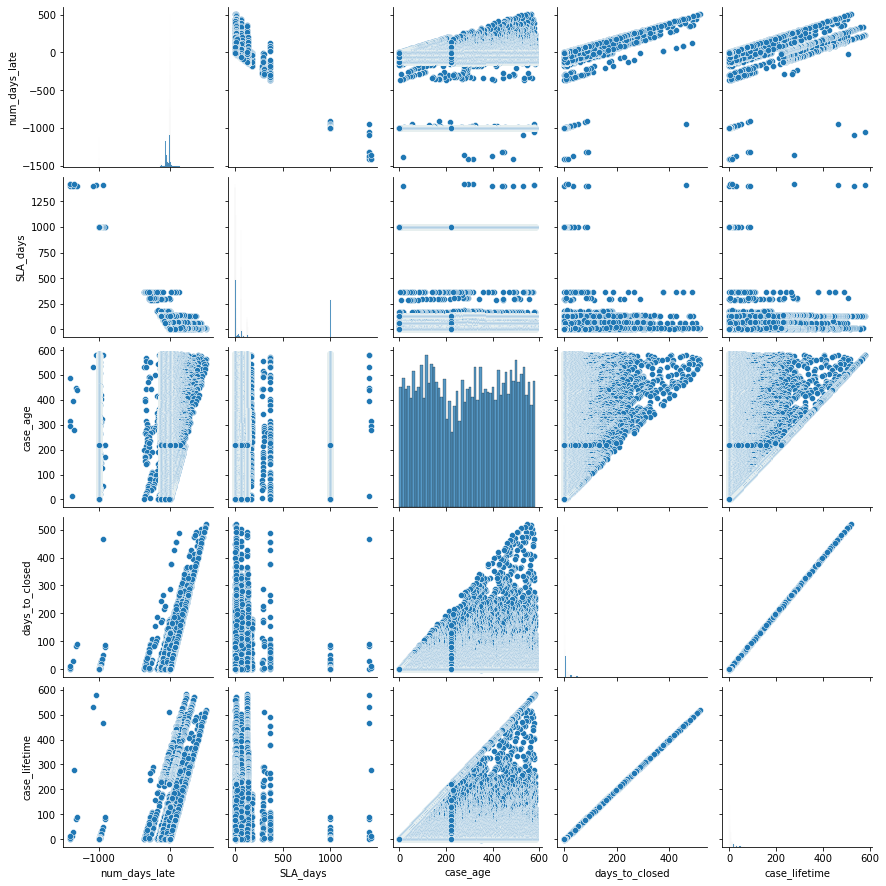

In [8]:
numeric_cols = ['num_days_late', 'SLA_days', 'case_age', 'days_to_closed', 'case_lifetime']

sns.pairplot(pdf[numeric_cols])

<AxesSubplot:ylabel='Frequency'>

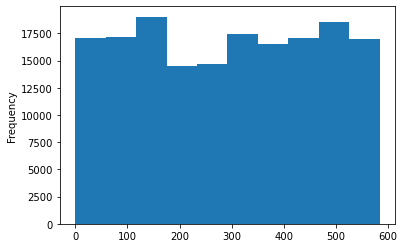

In [6]:
pdf.case_age.plot.hist()

<AxesSubplot:xlabel='department', ylabel='case_late'>

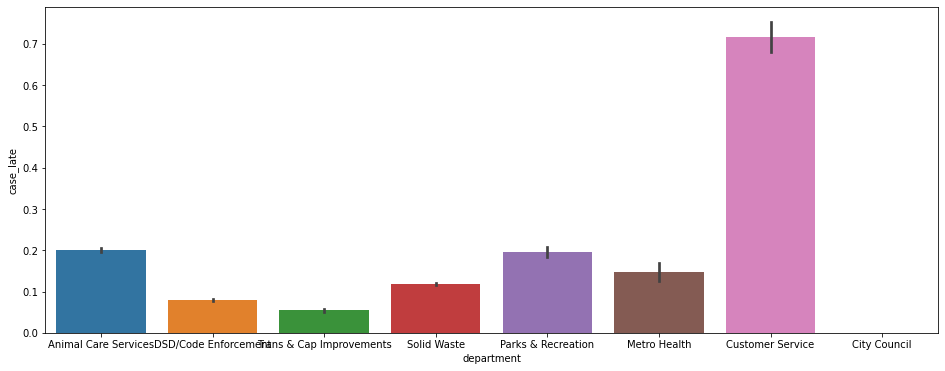

In [10]:
plt.figure(figsize=(16,6))
sns.barplot(pdf.department, pdf.case_late)

Re-sample with a different seed to see if we get similar results

<AxesSubplot:xlabel='department', ylabel='case_late'>

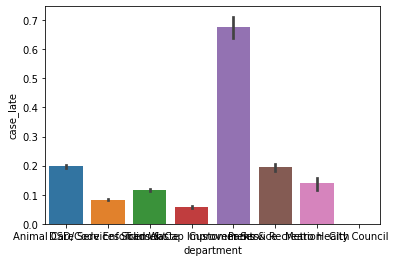

In [11]:
pdf_sample2 = sdf.sample(fraction=0.20, seed=447).toPandas()
sns.barplot(pdf_sample2.department, pdf_sample2.case_late)

## Strategy 3: Aggregate with spark, and then work with the aggregated data using Pandas

What does the case lifetime look like for each department?

In [12]:
#aggregate in spark and convert to pandas
df.groupby('department').count().toPandas()


,department,count
0,Solid Waste,279270
1,Animal Care Services,116915
2,Trans & Cap Improvements,96193
3,Parks & Recreation,19907
4,Customer Service,2849
5,Metro Health,5163
6,City Council,33
7,DSD/Code Enforcement,321374


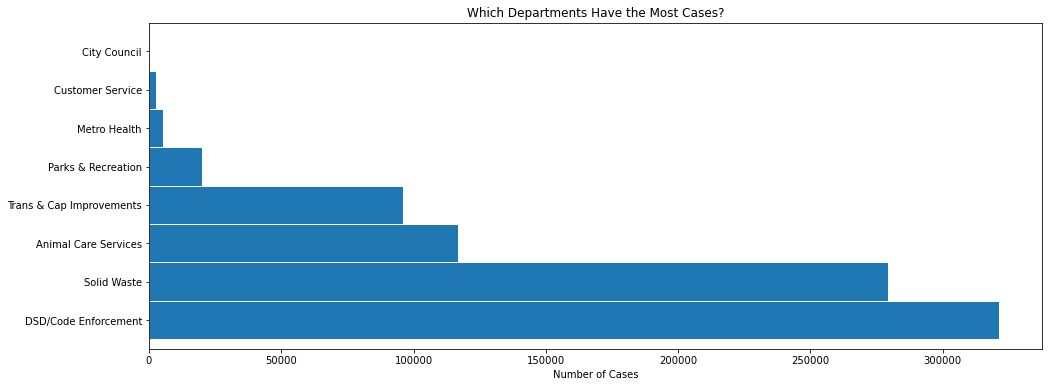

In [14]:
(
    df.groupby('department').count()
    .toPandas()
    .set_index('department')['count']
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="white", figsize=(16,6))
)

plt.title("Which Departments Have the Most Cases?")
plt.ylabel("")
plt.xlabel("Number of Cases")
plt.show()

What does the case lifetime look for each department?

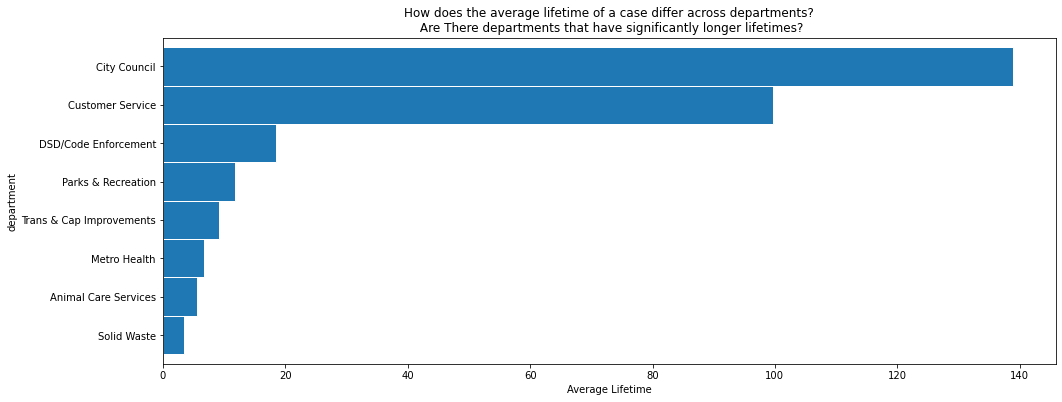

In [20]:
(
    sdf.groupBy("department")
    .agg(mean("case_lifetime").alias("mean_lifetime"))
    .toPandas()
    .set_index("department")
    .mean_lifetime.sort_values(ascending=True)
    .plot.barh(width=1, edgecolor="white", figsize=(16, 6))
)

plt.title("How does the average lifetime of a case differ across departments?\n Are There departments that have significantly longer lifetimes?")
plt.xlabel("Average Lifetime")
plt.show()

Let's Control for Case Status and then look at average lifetime by department.

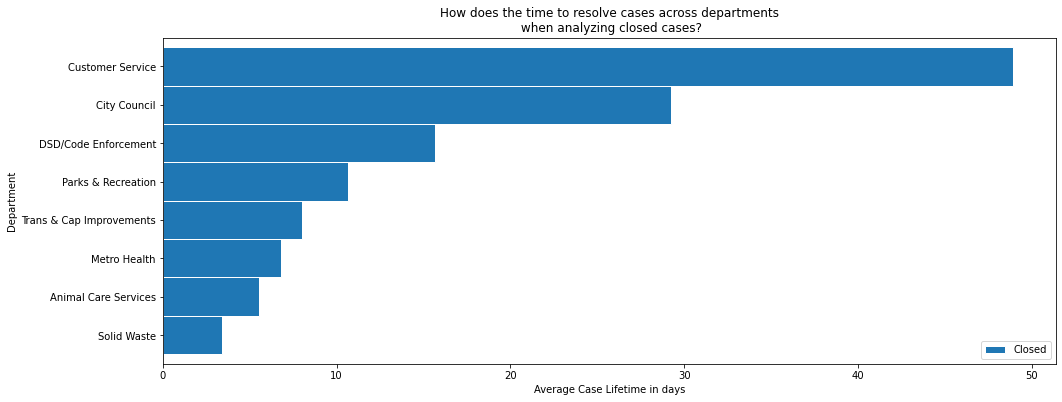

In [26]:
(
    df.groupBy("department")
    .pivot("case_status")
    .agg(round(mean("case_lifetime"), 2))
    .orderBy("Closed")
    .select("department", "Closed")
    .toPandas()
    .set_index('department')
    .plot.barh(width=1, edgecolor='white', figsize=(16,6))

)

plt.xlabel("Average Case Lifetime in days")
plt.ylabel("Department")
plt.title("How does the time to resolve cases across departments\n when analyzing closed cases?")

plt.show()

In [28]:
cases_by_day = sdf.select(
    "department",
    date_format("case_opened_date",
                "yyyy-MM-dd").alias("case_opened_date"),
    date_format("case_closed_date",
               "yyyy-MM-dd").alias("case_closed_date")
)

cases_by_day.show(5)

+--------------------+----------------+----------------+
|          department|case_opened_date|case_closed_date|
+--------------------+----------------+----------------+
|Animal Care Services|      2018-01-01|      2018-01-01|
|Trans & Cap Impro...|      2018-01-01|      2018-01-03|
|Trans & Cap Impro...|      2018-01-01|      2018-01-02|
|DSD/Code Enforcement|      2018-01-01|      2018-01-02|
|Animal Care Services|      2018-01-01|      2018-01-01|
+--------------------+----------------+----------------+
only showing top 5 rows



In [32]:
cases_opened_by_day = (
    cases_by_day
    .groupBy("case_opened_date")
    .count()
    .na.drop()
    .sort("case_opened_date")
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')['count']

)
cases_opened_by_day.name = 'cases_opened'

In [33]:
cases_closed_by_day = (
    cases_by_day
    .groupBy("case_closed_date")
    .count()
    .na.drop()
    .sort("case_closed_date")
    .toPandas()
    .assign(case_closed_date=lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')['count']

)
cases_closed_by_day.name = 'cases_closed'

In [36]:
pdf = pd.concat([cases_opened_by_day, cases_closed_by_day], axis=1)
pdf.head()

,cases_opened,cases_closed
2017-01-01,155,67
2017-01-02,1397,385
2017-01-03,1760,734
2017-01-04,1613,1206
2017-01-05,1791,1173


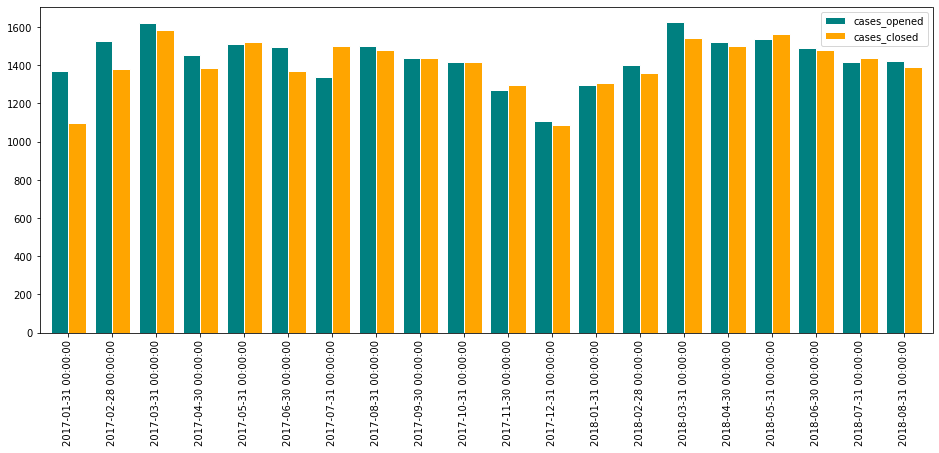

In [38]:
pdf.resample("M").mean().plot.bar(figsize=(16,6), width=.8, ec='white', color=['teal', 'orange'])

ticks, labels = plt.xticks()
labels = pd.to_datetime([l.get_text() for l in labels]).strftime("%m-%y")